In [1]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [2]:
#Load data
train = pd.read_csv("/Users/Lawrence/Desktop/Georgetown_G1/PPOL_564_DS/coding_discussions_ppol564_fall2021/06_coding_discussion/train_data.csv")
test = pd.read_csv("/Users/Lawrence/Desktop/Georgetown_G1/PPOL_564_DS/coding_discussions_ppol564_fall2021/06_coding_discussion/test_data.csv")

<AxesSubplot:>

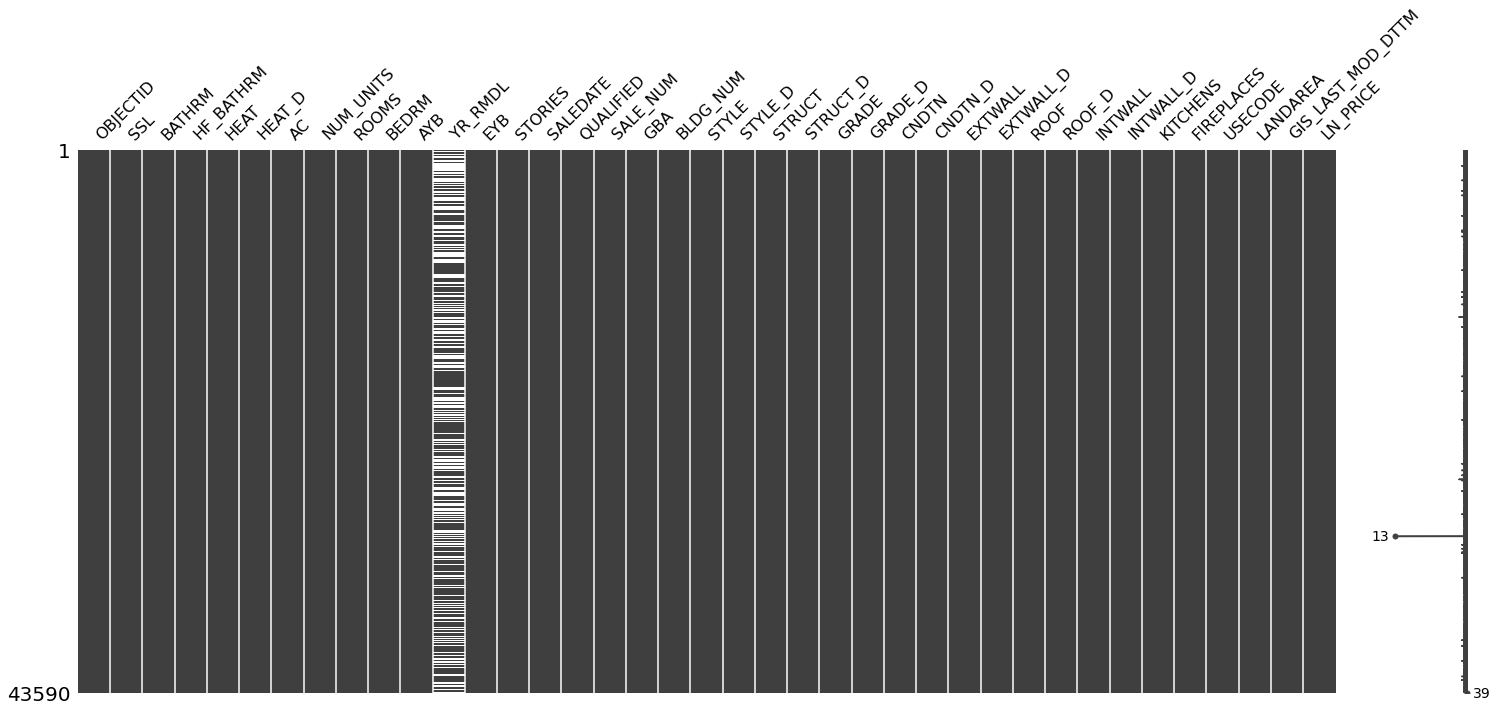

In [3]:
miss.matrix(train)

In [4]:
# Data Cleaning
train = train.dropna()
train_y = train['LN_PRICE']
train['LANDAREA'] = np.log(train['LANDAREA'])
train_x = train[["HF_BATHRM","KITCHENS","ROOMS","BEDRM","BATHRM","LANDAREA"]]

In [5]:
train_x.shape

(24998, 6)

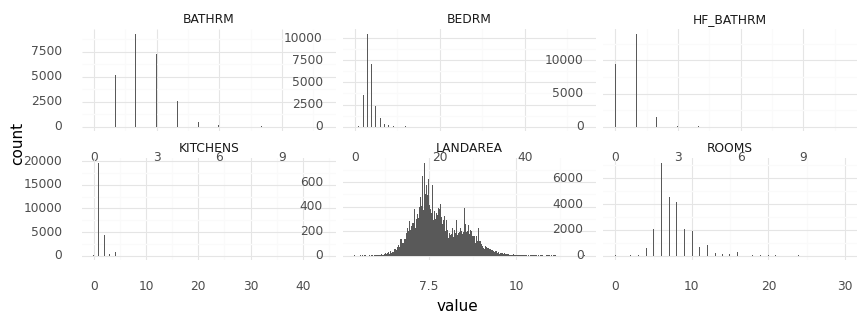

<ggplot: (8775509368649)>

In [6]:
(
    ggplot(train_x.melt(), aes(x='value')) +
    geom_histogram()+
    facet_wrap("variable", scales = "free")+
    theme_minimal()+
    theme(figure_size = (10,3))
)

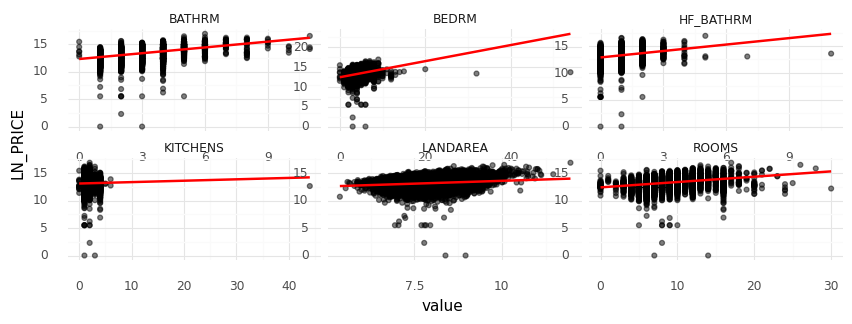

<ggplot: (8775593541383)>

In [7]:
D = train_x.copy()
D['LN_PRICE'] = train_y

(
    ggplot(D.melt(id_vars = ['LN_PRICE']),
          aes(x='value', y='LN_PRICE'))+
    geom_point(alpha=.5)+
    facet_wrap('variable', scales = 'free') +
    geom_smooth(method="lm", se= False, color = 'red')+
    theme_minimal() +
    theme(figure_size = (10,3))
)

In [8]:
# 1 Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits = 5, shuffle = True, random_state = 111)

In [9]:
# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), 
                                              ["HF_BATHRM","KITCHENS","ROOMS","BEDRM","BATHRM","LANDAREA"])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['HF_BATHRM',
                                                                          'KITCHENS',
                                                                          'ROOMS',
                                                                          'BEDRM',
                                                                          'BATHRM',
                                                                          'LANDAREA'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor(

In [10]:
search.best_score_ # Mean out-of-sample error

-0.41811788491519886

In [11]:
search.best_params_

{'model': KNeighborsRegressor(n_neighbors=30), 'model__n_neighbors': 30}

In [12]:
test = test.dropna()
test_y = test['LN_PRICE']
test['LANDAREA'] = np.log(test['LANDAREA'])
test_x = test[["HF_BATHRM","KITCHENS","ROOMS","BEDRM","BATHRM","LANDAREA"]]

In [13]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_x)

In [14]:
#Show the mean square error.
m.mean_squared_error(test_y,pred_y)

0.3967494364224963

In [16]:
m.r2_score(test_y,pred_y)

0.3453034258270167

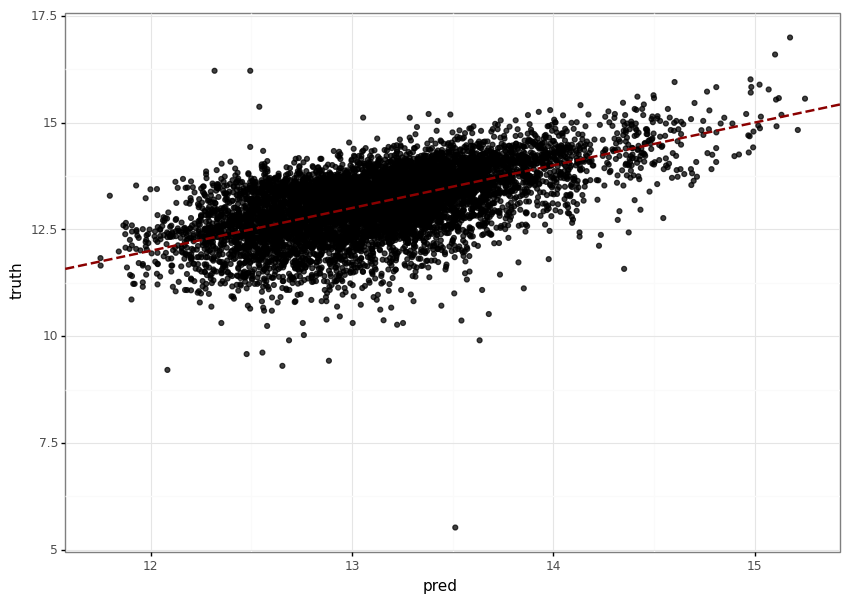

<ggplot: (8775541039604)>

In [15]:
#Visualize
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

It shows The KNN model fits the best. The MSE is 0.397 and R-squared is 0.345. 